# Response Spectrum Example

This notebook accessed ground motion data from a published project (PRJ-3941v5) and computes response spectra using a frequency domain solution to the convolution integral. The notebook demonstrates the following:

1. How to directly access data in a published project without downloading or moving it.
2. How to parse AT2 text files to load ground motion data into Numpy arrays.
3. How to save Numpy array objects for speed and efficiency
4. How to compute response spectra using native Python loops (slow)
5. How to compute response spectra using vectorized Python code (much faster!)
6. How to compute response spectra using JAX (Numpy on steroids, fastest!!)

## Paths to data files in DesignSafe

The primary file system used by DesignSafe is called Corral, and users can access different directories on Corral using procedures defined at https://www.designsafe-ci.org/rw/user-guides/data-transfer-guide/setting-the-path-to-designsafe-on-corral/. These procedures are intended for file-transfer utilities, such as Globus, the Tapis-cli, or an FTP client like Cyberduck. The paths have to be specified slightly differently in Jupyter to access MyData, Projects, Published, or Published (NEES) data. The path in a Jupyter notebook must be set as shown below. You should add additional directories to these paths to access files within those folders.

### MyData

/home/jupyter/MyData/

### MyProjects

/home/jupyter/projects/

### Published

/home/jupyter/NHERI-Published/

### Published (NEES)

/home/jupyter/NEES/


## Response spectrum solution

A response spectrum quantifies the peak response of an elastic, damped single-degree-of-freedom (SDOF) oscillator subject to an input ground motion at the base. For an SDOF oscillator with natural period $T_n$ and damping $D$, subjected to an input motion with acceleration amplitude $\ddot{u}_g$ and frequency $f$ the solution for the acceleration of the mass $\ddot{u}$ is:

$\ddot{u} = \frac{\ddot{u}_g}{1 + 2j D f T_n - \left(f T_n \right)^2}$

Earthquake ground motions are broadband rather than harmonic, so the equation above cannot be used directly to solve for the response of an SDOF oscillator to an earthquake ground motion. The approach adopted here is to decompose the earthquake ground motion using a Fourier transform, solve for the response of the oscillator to each frequency component in the signal, and subsequently use an inverse Fourier transform to synthesize the response. Assuming we have decomposed the base acceleration into $u$ different frequency components defined by the complex valued $F\ddot{u}_g$, the frequency-domain solution is given by:

$F\ddot{u}_u = \frac{F\ddot{u}_{g,u}}{1 + 2j D f_u T_n - \left(f_u T_n \right)^2}$

# 1. Load acceleration data from PRJ-3941v5

The cells below show how to load acceleration data from published project PRJ-3941v5, cited below.   

Buckreis, T., B. Güryuva, A. İçen, O. Okcu, A. Altindal, M. Aydin, R. Pretell, A. Sandikkaya, O. Kale, A. Askan, S. Brandenberg, T. Kishida, S. Akkar, Y. Bozorgnia, J. Stewart. (2023) "Ground Motion Data from the 2023 Türkiye-Syria Earthquake Sequence." DesignSafe-CI.

https://doi.org/10.17603/ds2-t115-bk16


In [229]:
# Import all packages used in this notebook

import os
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jit
from jax.numpy.fft import rfft, irfft, rfftfreq

# specify path to project. You can find these paths by browsing through the Jupyter lab folders
# in the panel to the left, but project names are not present there, so you'll need to know the
# project number. It's probably best to find those through the DesignSafe data depot browser.

path = "/home/jupyter/NHERI-Published/PRJ-3941v5/Acceleration Time-Series (2024-02-10)/2023-02-06 01-18-10 (UTC) M7.81 Pazarcik Earthquake (us6000jllz)/"

# create a list of all of the .AT2 files in the directory above

files = [x for x in os.listdir(path) if x[-4:] == '.AT2']

In [230]:
# Write function to parse ground the motion data and return the time step and acceleration array

def read_at2(file):
    with open(file) as f:
        for i in range(3):
            f.readline()
        line = f.readline()
        line_list = line.split('=')
        dt = float(line_list[2].strip().split(' ')[0])
        acc = np.asarray([],dtype=float)
        for line in f:
            line_array = np.asarray(re.split(' +',line.strip()),dtype=float)
            acc = np.hstack((acc,line_array))
        return [dt, acc]

In [231]:
# read the first 10 files. There are many more files than this, but we're sticking with only 10
# to reduce compute times for this demonstration

dt = []
acc = []
files = files[0:10]
for f in files:
    dt_temp, acc_temp = read_at2(path + f)
    dt.append(dt_temp)
    acc.append(acc_temp)

# 2. Parse acceleration data into Numpy arrays

In step 1, we stored the time step and acceleration data in Python lists. Lists are very convenient and flexible structures for storing data, but they are not particularly efficient becuase they can contain anything. For example, you could make a list that stores a mix of strings, floating point numbers, Booleans, objects, arrays, etc. This is all made possible by the Python interpreter, which analyzes the list to understand the data type stored within it. In this case, the time step data and the acceleration data have a known type, and can be stored as Numpy arrays instead of lists. Numpy arrays are much more efficient to work with because they facilitate vectorized calculations. In this case, the acceleration records have different numbers of data points, so we can't store the acceleration data in a regular Numpy array with dtype=float. So we store it as an object instead.

In [232]:
# Save the acceleration data as a numpy object so we don't have to read
# all those files each time

acc = np.asarray(acc,dtype=object)
dt = np.asarray(dt)

# 3. Save the data in a Numpy array format for speed and efficiency  

Parsing those text files and loading the data into a Numpy array took some time. We only read 10 text files, so the amount of time is not too bad. But if we tried to read all of the text files, it would take a long time. We wouldn't want to repeat those steps every time we want to use the data, so we will save the data in a Numpy array structure here for more efficient loading.

In [233]:
# save the acceleration and time step data in a Numpy array object. We must use 
# allow_pickle=True in order to store this data because it's stored as an object rather than
# as a simple NDArray object. For simpler arrays, the allow_pickle option can be omitted.

np.save('M7_8_acc_data.npy',np.asarray([acc,dt],dtype=object),allow_pickle=True)

In [234]:
# Just for fun, let's compare the time required to parse the text files and compare it with
# the time required to load the data from the Numpy array object that we just saved.

start_time = time.time()
dt = []
acc = []
files = files[0:10]
for f in files:
    dt_temp, acc_temp = read_at2(path + f)
    dt.append(dt_temp)
    acc.append(acc_temp)
end_time = time.time()
time1 = end_time - start_time
print('Execution time to parse text files: ' + str(time1) + ' s')

start_time = time.time()
acc, dt = np.load('M7_8_acc_data.npy',allow_pickle=True)
end_time = time.time()
time2 = end_time - start_time
print('Execution time to parse Numpy array object: ' + str(time2) + ' s')
print('Loading the Numpy array is ' + str(time1/time2) + ' times faster!')

Execution time to parse text files: 1.3973050117492676 s
Execution time to parse Numpy array object: 0.010106086730957031 s
Loading the Numpy array is 138.26370670944607 times faster!


# 4. Compute response spectra using native Python loops

The cells below will use Python loops to compute the response spectra for the 10 motions. The Python loops are inefficient due to the overhead associated with the Python interpreter. We first define a few constants and functions that will also be used in subsequent cells for the vectorized and JAX implementations

In [235]:
# Define spectral periods and damping value. These spectral periods are from the NGAWest2 project

T = np.asarray([0.01, 0.02, 0.022, 0.025, 0.029, 0.030, 0.032, 0.035, 0.036, 0.040, 0.042, 0.044, 0.045, 0.046, 0.048, 0.050, 0.055, 0.060, 0.065, 0.067, 0.070, 0.075, 0.080, 0.085, 0.090, 0.095, 0.100, 0.11, 0.12, 0.13, 0.133, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.22, 0.24, 0.25, 0.26, 0.28, 0.29, 0.30, 0.32, 0.34, 0.35, 0.36, 0.38, 0.40, 0.42, 0.44, 0.45, 0.46, 0.48, 0.50, 0.55, 0.60, 0.65, 0.667, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4, 2.5, 2.6, 2.8, 3.0, 3.2, 3.4, 3.5, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 20.0], dtype=float)
D = 0.05

In [236]:
# Fast Fourier transform algorithms are most efficient when the number of data points is equal to
# 2^I, 3^I, or 5^I, where I is a constant. We therefore pad with zeros before computing the FFT.

def next_fast_len(target):
    """
    Return a number of datapoints for efficient calculation of fast Fourier transform. 
    Used in zero padding
    """
    I2 = np.ceil(np.log2(target))
    I3 = np.ceil(np.log(target) / np.log(3))
    I5 = np.ceil(np.log(target) / np.log(5))
    
    return int(np.min([2**I2, 3**I3, 5**I5]))

In [237]:
# Write a function that uses Python loops to perform convolution and solve for spectral acceleration

def get_response_spectrum(acc, T, D, dt):
    """
    *args
    acc = Numpy array of acceleration values
    T = Numpy array of spectral periods for response spectrum
    D = scalar valued damping constant (decimal)
    dt = scalar valued time step (s)
    """
    NFFT = next_fast_len(len(acc))
    acc_padded = np.hstack((acc, np.zeros(NFFT - len(acc), dtype=float)))
    Facc = np.fft.rfft(acc_padded)
    freq = np.fft.rfftfreq(NFFT, d=dt)
    Facc_convolved = np.empty(len(Facc), dtype='complex')
    Sa = np.empty(len(T), dtype='float')
    for j in range(len(T)):
        for u in range(len(freq)):
            Facc_convolved[u] = Facc[u]/(1.0 + 2.0j * D * freq[u] * T[j] - freq[u]**2 * T[j]**2)
        convolved_acc = np.fft.irfft(Facc_convolved)
        Sa[j] = np.max(np.abs(convolved_acc))
    return Sa

In [238]:
import time

Sa1 = np.empty((len(acc),len(T)), dtype=float)
start_time = time.time()
for i in range(len(acc)):
    Sa1[i] = get_response_spectrum(acc[i], T, D, dt[i])
end_time = time.time()
time1 = end_time - start_time
print('Execution time = ' + str(end_time - start_time) + ' s')

Execution time = 40.122429847717285 s


# 5. Compute response spectra using vectorized Numpy

The Python loops above are slow because the interpreter does a lot of work each time the loop executes. Since we know the data structure here, the interpreter doesn't need to do all that work, and we can used vectorization to move the loops out of Python and into compiled Numpy scripts.

## A note on Numpy broadcasting

When we vectorize calculations using Numpy arrays, Numpy makes assumptions about what we want to do. If we multiply an array by a scalar, Numpy assumes that we want each value of the array to be multipled by the scalar. If we multiply two arrays of the same shape, Numpy assumes that we want an element-wise multiplication operation (i.e., the Hadamard product). If we multiply an array with shape MxN by an array of shape N, Numpy assumes that we want we get element-wise multiplication and the output is an MxN array. Things become a bit trickier when we try to multiply two arrays with different sizes. 

In the response spectrum calculation, the frequency array and period array have different sizes, and cannot be directly multiplied by each other in a vectorized calculation. However, they have to be multiplied together in the transfer function equation. We must handle this using "Broadcasting", which is described in more detail at the link below. In this case, we utilize the Numpy "newaxis" command to broadcast the array of natural periods so that it has an extra dimension that is the same shape as the frequency array. If we have N number of natural periods and M number of frequency components, the np.newaxis command will broadcast the period array into an NxM array, thereby enabling vectorized multiplication with the frequency array. The result is an NxM array.

https://numpy.org/doc/stable/user/basics.broadcasting.html

In [239]:
# Broadcasting examples

# array multiplied by scalar
arr1 = np.asarray([1.0,2.0,3.0])
s1 = 2.0
print(s1*arr1)

[2. 4. 6.]


In [240]:
# two arrays with same size
arr1 = np.asarray([1.0,2.0,3.0])
arr2 = np.asarray([2.0,3.0,4.0])
print(arr1*arr2)

[ 2.  6. 12.]


In [241]:
# two arrays with different size, but one dimension is the same
arr1 = np.asarray([[1.0,2.0,3.0],[2.0,3.0,4.0]])
arr2 = np.asarray([3.0,4.0,5.0])
print(arr1*arr2)

[[ 3.  8. 15.]
 [ 6. 12. 20.]]


In [242]:
# two arrays with different size. This doesn't work!!!
arr1 = np.asarray([1.0,2.0,3.0])
arr2 = np.asarray([3.0,4.0])
print(arr1*arr2)

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [243]:
# two arrays with different size using broacasting. This works!!!
arr1 = np.asarray([1.0,2.0,3.0])
arr2 = np.asarray([3.0,4.0])
print(arr1*arr2[:,np.newaxis])

[[ 3.  6.  9.]
 [ 4.  8. 12.]]


In [261]:
# Develop a vectorized function than avoids loops.

def get_response_spectrum_vectorized(acc, T, D, dt):
    """
    *args
    acc = Numpy array of acceleration values
    T = Numpy array of spectral periods for response spectrum
    D = scalar valued damping constant (decimal)
    dt = scalar valued time step (s)
    """
    NFFT = next_fast_len(len(acc))
    acc_padded = np.hstack((acc, np.zeros(NFFT - len(acc), dtype=float)))
    Facc = np.fft.rfft(acc_padded)
    freq = np.fft.rfftfreq(NFFT, d=dt)
    
    # broadcasting to eliminate inner loop
    f_squared = freq**2
    T_squared = T**2
    f_T = freq * T[:, np.newaxis]
    f_T2 = f_squared * T_squared[:, np.newaxis]
    denominator = 1.0 + 2.0j * D * f_T - f_T2
    Facc_convolved = Facc/denominator
    
    convolved_acc = np.fft.irfft(Facc_convolved)
    Sa = np.max(np.abs(convolved_acc), axis=1)
    return Sa

In [263]:
Sa2 = np.empty((len(acc),len(T)), dtype=float)
start_time = time.time()
for i in range(len(acc)):
    Sa2[i] = get_response_spectrum_vectorized(acc[i], T, D, dt[i])    
end_time = time.time()
time2 = end_time - start_time
print('Execution time = ' + str(end_time - start_time) + ' s')

Execution time = 2.1572887897491455 s


# 6. Compute response spectra using JAX and its just-in-time (JIT) compiler

JAX is Numpy that is configured to make use of high-performance computing resources. It has been called "Numpy on steroids" and can make use of parallel CPU and GPU computing. Just-in-time compiling tells the Python interpreter to compile the code at runtime, thereby avoiding the overhead imposed by the Python interpreter. The first time a JIT function is run, it is a bit slow because the runtime includes the compile time. The second and subsequent times the function is called it will be significantly faster.

In [270]:
@jit
def get_response_spectrum_vectorized_jax(acc, T, D, dt):
    NFFT = next_fast_len(len(acc))
    zeros = jnp.zeros(NFFT - len(acc), dtype=jnp.float32)
    acc = jnp.concatenate((acc, zeros))
    Facc = rfft(acc)
    freq = rfftfreq(NFFT, d=dt)
    Facc_convolved = Facc / (1.0 + 2.0j * D * freq * T[:, None] - freq**2 * T[:, None]**2)
    convolved_acc = irfft(Facc_convolved, n=NFFT)
    Sa = jnp.max(jnp.abs(convolved_acc), axis=1)
    return Sa

In [271]:
Sa3 = np.empty((len(acc),len(T)), dtype=float)
start_time = time.time()
for i in range(len(acc)):
    Sa3[i] = get_response_spectrum_vectorized_jax(acc[i], T, D, dt[i])    
end_time = time.time()
time3 = end_time - start_time
print('Execution time (first run) = ' + str(end_time - start_time) + ' s')
start_time = time.time()
for i in range(len(acc)):
    Sa3[i] = get_response_spectrum_vectorized_jax(acc[i], T, D, dt[i])    
end_time = time.time()
time4 = end_time - start_time
print('Execution time (second run) = ' + str(end_time - start_time) + ' s')

Execution time (first run) = 1.324880838394165 s
Execution time (second run) = 0.4380950927734375 s


# Plot data

The native Python loops were very slow compared with the vectorized Python, and JAX + JIT calculations. Let's plot the data to make sure we have done the same thing each time

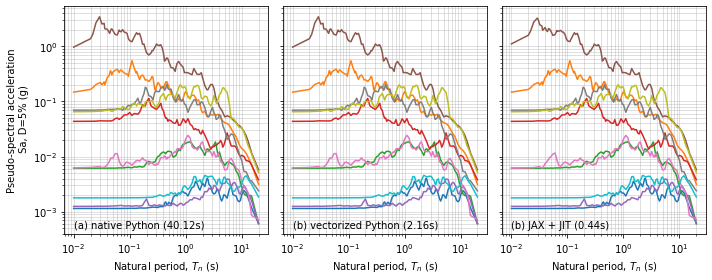

In [272]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3,figsize=(10,4),sharey='row')
for i in range(len(Sa)):
    ax[0].plot(T,Sa1[i])
    ax[1].plot(T,Sa2[i])
    ax[2].plot(T,Sa3[i])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].grid(True,alpha=0.5,which='both')
ax[1].grid(True,alpha=0.5,which='both')
ax[2].grid(True,alpha=0.5,which='both')
ax[0].set_xlabel(r'Natural period, $T_n$ (s)')
ax[0].set_ylabel('Pseudo-spectral acceleration\n Sa, D=5% (g)')
ax[1].set_xlabel(r'Natural period, $T_n$ (s)')
ax[2].set_xlabel(r'Natural period, $T_n$ (s)')
ax[0].annotate('(a) native Python (' + '{:.2f}'.format(time1) + 's)', xy=(0.01,0.0005))
ax[1].annotate('(b) vectorized Python (' + '{:.2f}'.format(time2) + 's)', xy=(0.01,0.0005))
ax[2].annotate('(b) JAX + JIT (' + '{:.2f}'.format(time4) + 's)', xy=(0.01,0.0005))
fig.tight_layout()